In [2]:
import numpy as np
import matplotlib.pyplot as plt

import os
import pickle

In [3]:
# load in the data

bands = ["SBL", "IBL", "SR", "IBH", "SBH"]
data_dict = {}

feature_set = [9, 10, 12]
num_features = len(feature_set) - 1 # context doesn't count
seed = 8

num_layers = 2
num_hidden_features = 16
num_blocks = 4
early_stop_patience = 10

flow_training_id = f"Masked_PRQ_AR_{num_layers}layers_{num_hidden_features}hidden_{num_blocks}blocks_{seed}seed"
flow_training_dir = os.path.join("models", f"{flow_training_id}/")

with open(f"models/{flow_training_id}/flow_samples", "rb") as infile:
    
    data_dict = pickle.load(infile)
    
print(data_dict.keys())

full_sup_sig = np.load("processed_data/full_sup_sig.npy")[:,feature_set]
full_sup_bkg = np.load("processed_data/full_sup_bkg.npy")[:,feature_set]
test_sig = np.load("processed_data/test_sig.npy")[:,feature_set]
test_bkg = np.load("processed_data/test_bkg.npy")[:,feature_set]



dict_keys(['SBL', 'IBL', 'SR', 'IBH', 'SBH', 'SB', 'IB', 'SBL_samples', 'SBH_samples', 'SB_samples', 'IBL_samples', 'IBH_samples', 'IB_samples', 'SR_samples'])


SBL


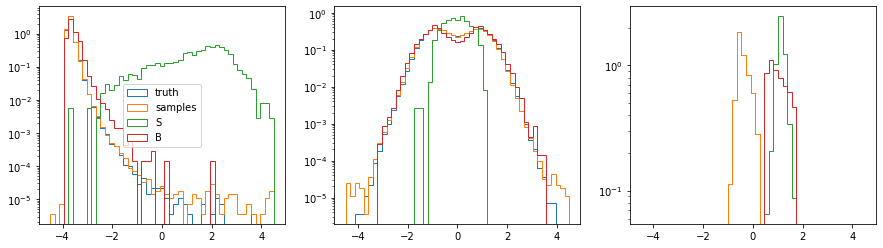

IBL


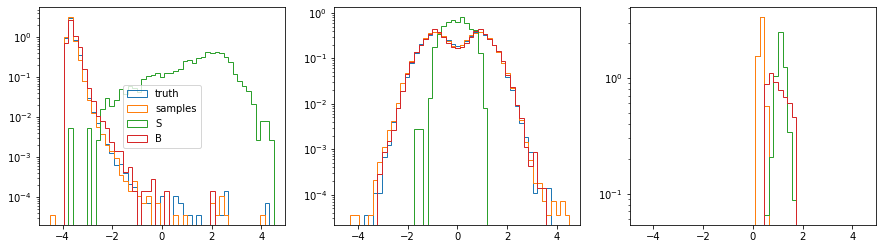

SR


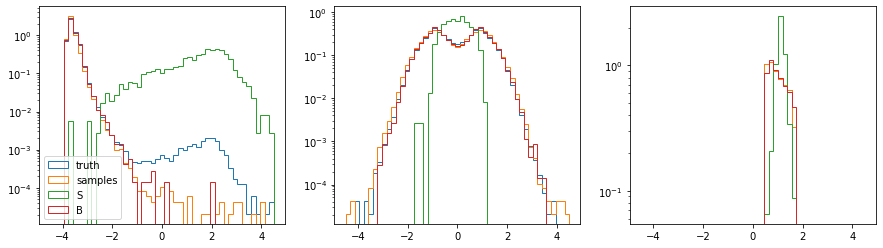

IBH


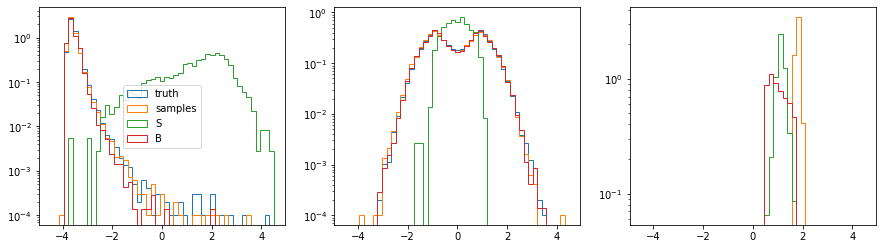

SBH


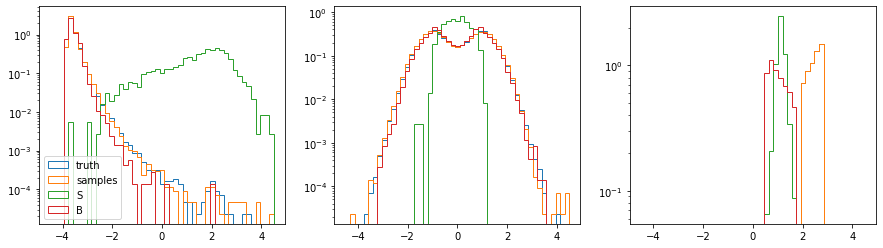

In [4]:
bins = np.linspace(-4.5, 4.5, 50)

for b in bands:
    
    print(b)
    
    
    fig, ax = plt.subplots(1, 3, figsize = (15, 4))
    for i, feature in enumerate(feature_set):
        ax[i].hist(data_dict[b][:,i], bins = bins, label = "truth", histtype = "step", density = "True")
        ax[i].hist(data_dict[f"{b}_samples"][:,i], bins = bins, label = "samples", histtype = "step", density = "true")
        ax[i].hist(test_sig[:,i], bins = bins, label = "S", histtype = "step", density = "True")
        ax[i].hist(test_bkg[:,i], bins = bins, label = "B", histtype = "step", density = "true")
        ax[i].set_yscale("log")
        
    ax[0].legend()
    plt.show()

In [15]:
# samples

datasets = {
    
    "samples": (data_dict["SR_samples"][:,:-1],  data_dict["SR"][:,:-1]),
    "full sup": (full_sup_bkg[:,:-1], full_sup_sig[:,:-1]),

}



Code adapted from https://github.com/mariehein/BackToTheRoots/tree/5619eb225679b1cafe3eaa0d8095bb06007aeb63

In [16]:
# discrim SR events from SR samples

from sklearn.ensemble import HistGradientBoostingClassifier
from sklearn.metrics import roc_curve, roc_auc_score

def run_BDTs(train_samp_0, train_samp_1, test_samp_0, test_samp_1, num_to_ensemble):
    

    X_train = np.vstack((train_samp_0, train_samp_1))
    Y_train = np.vstack((np.zeros((train_samp_0.shape[0], 1)), np.ones((train_samp_1.shape[0], 1))))

    X_test = np.vstack((test_samp_0, test_samp_1))
    Y_test = np.vstack((np.zeros((test_samp_0.shape[0], 1)), np.ones((test_samp_1.shape[0], 1))))
    
    print(X_train.shape, Y_train.shape)

    class_weight = {0: 1, 1: sum(Y_train==0)[0]/sum(Y_train==1)[0]}
    class_weights = class_weight[0]*(1.0-Y_train)+class_weight[1]*Y_train
    Y_train = Y_train.reshape(-1,)
    Y_test = Y_test.reshape(-1,)
    class_weights = class_weights.reshape(-1,)

    print("\nTraining class weights: ", class_weight)

    scores = np.zeros((num_to_ensemble,len(X_test)))

    for i in range(num_to_ensemble):
        
        print("Tree number:", i)
        np.random.seed(i+1)
        
        tree = HistGradientBoostingClassifier(verbose=0, max_iter=200, max_leaf_nodes=31, validation_fraction=0.5)
        results_f = tree.fit(X_train, Y_train, sample_weight=class_weights)
        scores[i] = tree.predict_proba(X_test)[:,1]
        """
        # plot roc
        fpr, tpr, _ = roc_curve(Y_test, scores[j])
        sic = tpr / np.sqrt(fpr)
        plt.figure()
        plt.plot(tpr, sic)
        plt.xlabel("tpr")
        plt.ylabel("sic")
        plt.show()
        """
        
        del results_f
        
    print("All done!")
    return scores

In [17]:
# discrim SR events from SR samples

from helpers.train_BC import *
from numba import cuda

device = cuda.get_current_device()
device.reset()
torch.set_num_threads(2)
device = torch.device( "cuda" if torch.cuda.is_available() else "cpu")
print( "Using device: " + str( device ), flush=True)

def run_NNs(train_samp_0, train_samp_1, test_samp_0, test_samp_1, num_to_ensemble):
    
    hyperparameters_dict_BC = {"n_epochs":50,
                              "batch_size": 512,
                              "lr": 0.001,
                             }

    scores = np.zeros((num_to_ensemble,len(test_samp_0)+len(test_samp_1)))
    
    for i in range(num_to_ensemble):
        auc, fpr, tpr, outputs = discriminate_datasets_kfold("tmp", train_samp_0,  train_samp_1, 
                                np.ones((train_samp_0.shape[0],1)), np.ones((train_samp_1.shape[0],1)), 
                                   test_samp_0, test_samp_1, train_samp_0.shape[1], 
                                hyperparameters_dict_BC, device, seed = i+1, visualize = False, k_folds = 2)

        """
        fig, ax = plt.subplots(1, 1, figsize=(7, 5))
        ax.plot(fpr, tpr)
        ax.set_xlabel("FPR")
        ax.set_ylabel("TPR")
        ax.set_title("ROC: " + str(auc))
        """
        
        scores[i] = outputs.reshape(-1,)

    print("All done!")
    return scores

Using device: cuda


In [20]:
num_runs = 3

scores_bdt = {}

for run_id in datasets.keys():
    print(run_id)
    scores_bdt[run_id] = run_BDTs(datasets[run_id][0], datasets[run_id][1], test_bkg[:,:-1], test_sig[:,:-1], num_runs)


samples
(524696, 2) (524696, 1)

Training class weights:  {0: 1, 1: 1.0}
Tree number: 0
Tree number: 1
Tree number: 2
All done!
full sup
(3000, 2) (3000, 1)

Training class weights:  {0: 1, 1: 1.0}
Tree number: 0
Tree number: 1
Tree number: 2
All done!


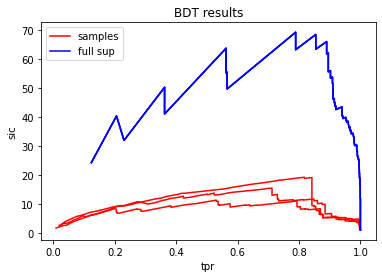

In [13]:
colors = ["red", "blue"]

with np.errstate(divide='ignore', invalid='ignore'):

    plt.figure()
    
    for j, run_id in enumerate(datasets.keys()):

        for i in range(num_runs):
            fpr, tpr, _ = roc_curve(Y_test, scores_bdt[run_id][i])
            sic = np.divide(tpr, np.sqrt(fpr))
                               
            label = ""
            if i == 0: label = run_id
            plt.plot(tpr, sic, color = colors[j], label = label)
    
    plt.xlabel("tpr")
    plt.ylabel("sic")
    
    plt.legend()
    
    plt.title("BDT results")

    plt.show()



In [10]:

scores_nn = {}

for run_id in datasets.keys():
    print(run_id)
    scores_nn[run_id] = run_NNs(datasets[run_id][0], datasets[run_id][1], test_bkg[:,:-1], test_sig[:,:-1], num_runs)

    
    

Using seed 1...
Train data, labels shape: (524696, 2) (524696, 1)
Test data, labels  shape: (43500, 2) (43500, 1)


  0%|          | 0/50 [00:00<?, ?it/s]

FOLD 0
--------------------------------


  0%|          | 0/50 [00:00<?, ?it/s]

Done training fold 0. Best val loss 0.6851866245269775 at epoch 31
FOLD 1
--------------------------------


  0%|          | 0/50 [00:00<?, ?it/s]

Done training fold 1. Best val loss 0.6845863461494446 at epoch 33
Loading in best model for tmp/.bc_fold1.pt, val loss 0.6845863461494446 from fold 1
Using seed 2...
Train data, labels shape: (524696, 2) (524696, 1)
Test data, labels  shape: (43500, 2) (43500, 1)
FOLD 0
--------------------------------


  0%|          | 0/50 [00:00<?, ?it/s]

Done training fold 0. Best val loss 0.6850849986076355 at epoch 30
FOLD 1
--------------------------------


  0%|          | 0/50 [00:00<?, ?it/s]

Done training fold 1. Best val loss 0.6840917468070984 at epoch 37
Loading in best model for tmp/.bc_fold1.pt, val loss 0.6840917468070984 from fold 1
Using seed 3...
Train data, labels shape: (524696, 2) (524696, 1)
Test data, labels  shape: (43500, 2) (43500, 1)
FOLD 0
--------------------------------


  0%|          | 0/50 [00:00<?, ?it/s]

Done training fold 0. Best val loss 0.6836628913879395 at epoch 38
FOLD 1
--------------------------------


 84%|████████▍ | 42/50 [03:30<00:40,  5.02s/it]

Done training fold 1. Best val loss 0.6854696273803711 at epoch 37
Loading in best model for tmp/.bc_fold0.pt, val loss 0.6836628913879395 from fold 0
All done!


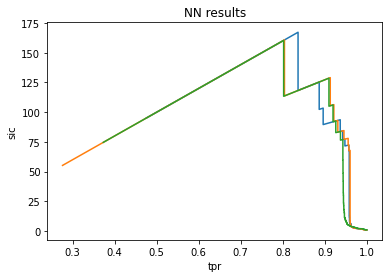

0.9873459095238095


In [11]:
colors = ["red", "blue"]

with np.errstate(divide='ignore', invalid='ignore'):

    plt.figure()
    
    for j, run_id in enumerate(datasets.keys()):

        for i in range(num_runs):
            fpr, tpr, _ = roc_curve(Y_test, scores_nn[run_id][i])
            sic = np.divide(tpr, np.sqrt(fpr))
                               
            label = ""
            if i == 0: label = run_id
            plt.plot(tpr, sic, color = colors[j], label = label)
    
    plt.xlabel("tpr")
    plt.ylabel("sic")
    
    plt.legend()
    
    plt.title("NN results")

    plt.show()


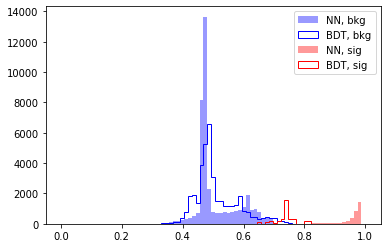

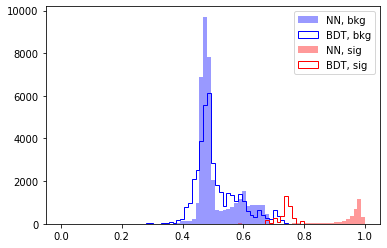

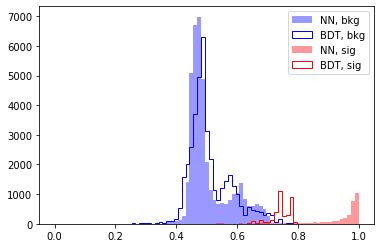

In [26]:

test_bkg.shape[0]

for i in range(3):
    
    plt.figure()
    plt.hist(scores_NN[i][:test_bkg.shape[0]], bins = np.linspace(0, 1, 80), histtype = "stepfilled", density = False, label = "NN, bkg", color = "blue", alpha = 0.4)
    plt.hist(scores_BDT[i][:test_bkg.shape[0]], bins = np.linspace(0, 1, 80), histtype = "step", density = False, label = "BDT, bkg", color = "blue")
    plt.hist(scores_NN[i][-test_sig.shape[0]:], bins = np.linspace(0, 1, 80), histtype = "stepfilled", density = False, label = "NN, sig", color = "red", alpha = 0.4)
    plt.hist(scores_BDT[i][-test_sig.shape[0]:], bins = np.linspace(0, 1, 80), histtype = "step", density = False, label = "BDT, sig", color = "red")
    plt.legend()
    plt.show()